In [ ]:
#| default_exp plotting

# plotting
> Plotting tools for Planet Four data

In [34]:
#| export
from matplotlib import pyplot as plt
from matplotlib import colormaps
import numpy as np
import pandas as pd
import matplotlib
from p4tools import io, markings

In [ ]:
#| export
def plot_blotches_for_tile(tile_id, ax=None, **plot_kwargs):
    tile_blotches = io.get_blotches_for_tile(tile_id)
    if ax is None:
        _, ax = plt.subplots()
    for _, blotch in tile_blotches.iterrows():
        m = markings.Blotch(blotch, with_center=False)
        m.plot(ax=ax, **plot_kwargs)

In [ ]:
tile_with_blotches = 'APF0000004'

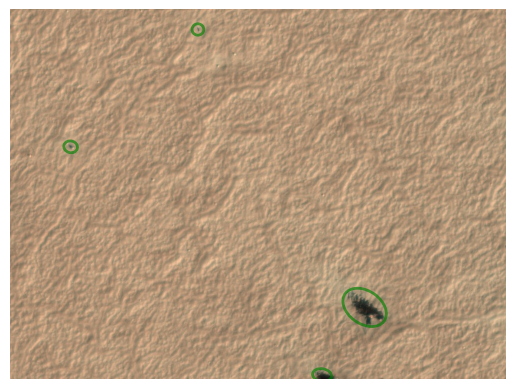

In [ ]:
plot_blotches_for_tile(tile_with_blotches)

In [ ]:
#| export
def plot_fans_for_tile(tile_id, ax=None, **plot_kwargs):
    tile_fans = io.get_fans_for_tile(tile_id)
    if len(tile_fans) == 0:
        print("Warning: No fans found.")
    if ax is None:
        _, ax = plt.subplots()
    for _, fan in tile_fans.iterrows():
        m = markings.Fan(fan, with_center=False)
        m.plot(ax=ax, **plot_kwargs)

In [ ]:
tile_with_fans = 'APF000000c'

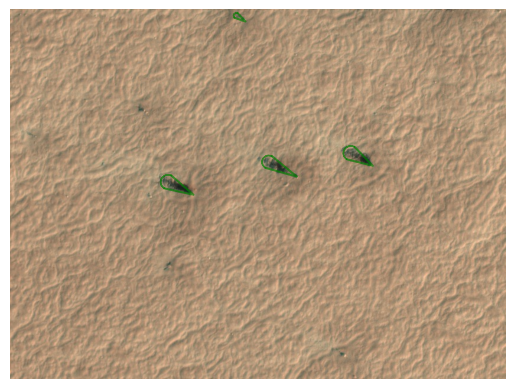

In [ ]:
plot_fans_for_tile(tile_with_fans)

In [ ]:
#| export
def plot_original_tile(tileID, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.imshow(io.get_subframe_by_tile_id(tileID), origin="upper", aspect="auto")
    ax.set_axis_off()

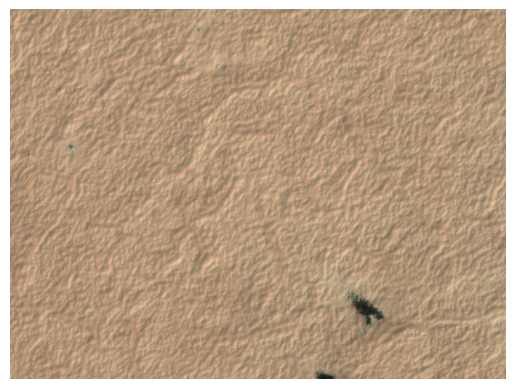

In [ ]:
plot_original_tile(tile_with_blotches)

In [ ]:
#| export
def plot_original_and_fans(tileID):
    fig, axes = plt.subplots(ncols=2, figsize=(9, 3))
    plot_original_tile(tileID, ax=axes[0])
    plot_fans_for_tile(tileID, ax=axes[1])
    fig.suptitle(f"Planet Four tile ID: {tileID}")

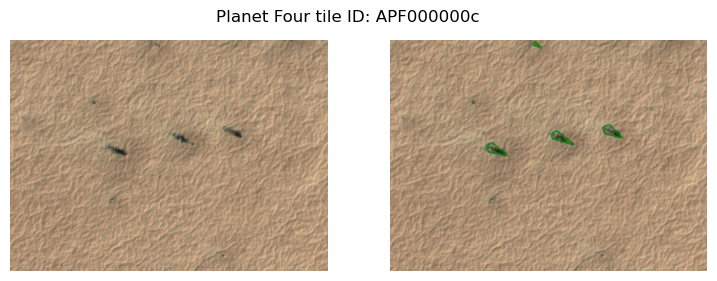

In [ ]:
plot_original_and_fans(tile_with_fans)

In [ ]:
#| export
def plot_original_and_blotches(tileID):
    fig, axes = plt.subplots(ncols=2, figsize=(9, 3))
    plot_original_tile(tileID, ax=axes[0])
    plot_blotches_for_tile(tileID, ax=axes[1], color="magenta")
    fig.suptitle(f"Planet Four tile ID: {tileID}")

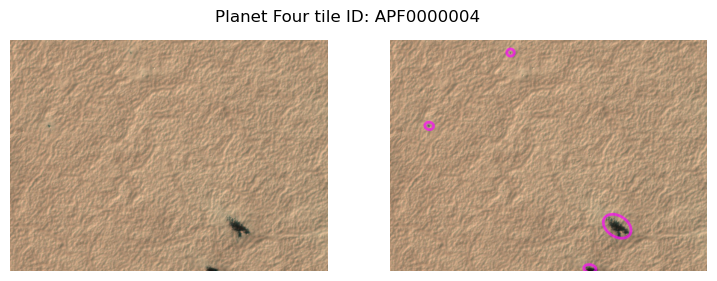

In [ ]:
plot_original_and_blotches(tile_with_blotches)

In [ ]:
#| export
def plot_original_fans_blotches(tileID, save=False):
    fig, axes = plt.subplots(ncols=2, figsize=(9, 3))
    plot_original_tile(tileID, ax=axes[0])
    plot_fans_for_tile(tileID, ax=axes[1])
    plot_blotches_for_tile(tileID, ax=axes[1], color="magenta")
    fig.suptitle(f"Planet Four tile ID: {tileID}")
    if save:
        fig.savefig(f"{tileID}.png", dpi=150)

In [ ]:
tile_with_both = 'APF0000006'

100%|███████████████████████████████████████| 163k/163k [00:00<00:00, 83.8MB/s]


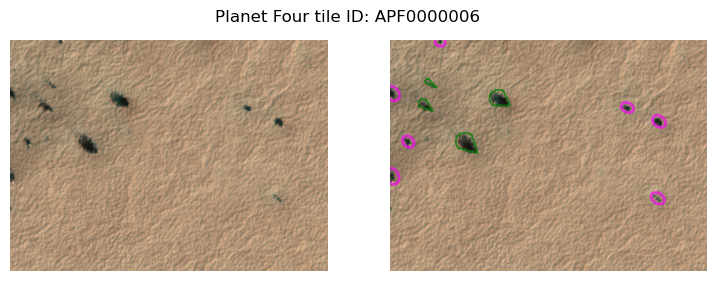

In [ ]:
plot_original_fans_blotches(tile_with_both)

In [ ]:
#| export
def plot_x_random_tiles_with_n_fans(
    x: int = 3,  # how many of 2 col original+p4 data plots to receive 
    n: int = 15,  # whats the minimum number of fans to contain
    save:
    bool = False,  # if True, saves a PNG with the plot for each tile_id separately
    random_state: int = None  # can be set to recreate the exact same set
):
    fans = io.get_fan_catalog()
    blotches = io.get_blotch_catalog()
    # for the fan tiles that have blotches, how many fans are in:
    n_fans = fans[fans.tile_id.isin(blotches.tile_id)].groupby("tile_id").size()
    tile_ids = n_fans[n_fans >= n].sample(x, random_state=random_state).index
    for tile_id in tile_ids:
        plot_original_fans_blotches(tile_id, save=save)

100%|████████████████████████████████████████| 254k/254k [00:00<00:00, 130MB/s]
100%|████████████████████████████████████████| 282k/282k [00:00<00:00, 147MB/s]


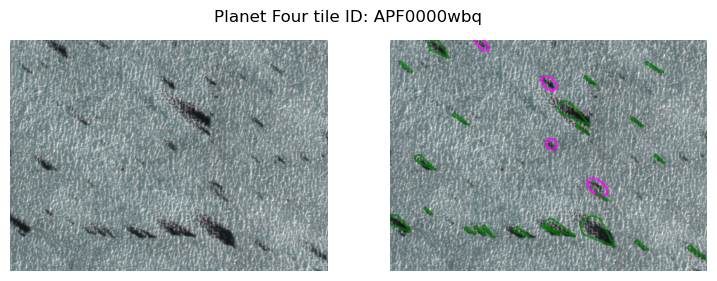

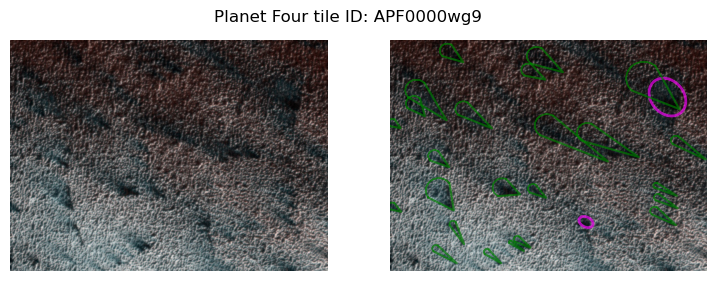

In [ ]:
plot_x_random_tiles_with_n_fans(2)

In [42]:
#| export

def compute_direction_histogram(df, segmentsize, density=True, degrees=False):
    
    direction = df["angle"]
    north_azimuth = df["north_azimuth"]
    direction = (direction - north_azimuth)%360
    bins = np.arange(0,360+segmentsize,segmentsize)
    if df.shape[0] != 0:
        counts,edges = np.histogram(direction,bins,density=density)
    else:
        #Maybe issue a warning
        return [0,0],[0,0]

    if not degrees:
        theta = np.deg2rad(bins)
    else: 
        theta = bins
        
    radii = counts
    return theta,radii


def initialize_polar_axes(ax : matplotlib.projections.polar.PolarAxes):
    """Initializes the Polar Axes to Wind Directions, counted in clockwise direction from N

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        An Matplotlib polar Axis
    """
    ax.set_theta_zero_location("N")
    ax.set_theta_direction("clockwise")
    ax.set_xticks(np.linspace(0,2*np.pi,8,endpoint=False))
    ax.set_xticklabels(["N","NE","E","SE","S","SW","W","NW"])
    ax.set_yticklabels([])



def get_colorscale(nr):
    color_scale = np.linspace(0,1,nr)
    if nr < 9:
        cmap = colormaps["Pastel1"]
    if nr < 20:   
        cmap = colormaps["tab20"]
    else:
        cmap = colormaps["turbo"]
    return cmap(color_scale)

def _get_filtered_index(df,ls_bin, per_obsid=False):

    indexes = []
    label_list = []
    if per_obsid:
        obsids = df.obsid.unique()
        for id in obsids:    
            ind = df.obsid == id
            indexes.append(ind)
            label_list.append(id)
        
        return indexes, label_list
    
    else:
        _,ls_bin = pd.cut(df.l_s, bins=ls_bin,retbins=True)

        for i,ls in enumerate(ls_bin[:-1]):

            ind = df.l_s.between(left=ls_bin[i],right=ls_bin[i+1])
            df_sub = df[ind]
            label1 = f"[{ls_bin[i]:.0f}, {ls_bin[i+1]:.0f}]"
            label2 = f"#Fans = {df_sub.shape[0]}"
            label3 = f"#images = {df_sub.obsid.unique().size}"
            label = label1 + "\n" + label2 + "\n" + label3

            indexes.append(ind)
            label_list.append(label)

        return indexes, label_list


def _draw_histogram(ax, df, ls_bin = 4, per_obsid=False, density = True, segmentsize=3.6, alpha=0.5, degrees=False, cutoff = None):

    indexes,label_list = _get_filtered_index(df,ls_bin,per_obsid)

    cmap = get_colorscale(len(indexes))


    for i in range(0,len(indexes)):
        df_sub = df[indexes[i]]

        if (cutoff is not None) and (df_sub.shape[0] < cutoff):
            continue
        
        label = label_list[i]
        theta, radii = compute_direction_histogram(df_sub, segmentsize, density=density, degrees=degrees)
        width = np.diff(theta)
        ax.bar(theta[:-1],radii, width=width, color=cmap[i],label=label, alpha=alpha)

    return ax

def histogram_polar(df,ls_bin = 4, per_obsid = False , segmentsize=3.6, alpha=0.5, cutoff = None,):
    """
    Plots a histogram in polar coordinates.
    Parameters:
    df : pandas.DataFrame
        The data frame containing the data to be plotted.
    ls_bin : int, optional
        The bin size for the histogram (default is 4).
    per_obsid : bool, optional
        If True, the histogram is plotted per observation ID (default is False).
    segmentsize : float, optional
        The size of each segment in the histogram (default is 3.6).
    alpha : float, optional
        The transparency level of the histogram bars (default is 0.5).
    cutoff : float, optional
        A cutoff value for the data (default is None).
    Returns:
    matplotlib.axes._subplots.PolarAxesSubplot
        The polar axes with the histogram plotted.
    """

    ax = plt.subplot(projection = "polar")
    ax = _draw_histogram(ax, df, ls_bin=ls_bin, per_obsid=per_obsid, segmentsize=segmentsize, alpha=alpha, cutoff= cutoff)
    initialize_polar_axes(ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    return ax

def histogram_cartesian(df, ls_bin = 4, segmentsize=3.6, alpha=0.5, degrees=True):
    ax = plt.subplot()
    ax = _draw_histogram(ax, df, ls_bin=ls_bin, density=False ,segmentsize=segmentsize, alpha=alpha, degrees=degrees)
    return ax

We can create an Inverse Windrose for a given region by filtering the dataframe for a number of obsids within the region. Here the example shows the lists of the obsids within the Potsdam region.

<PolarAxes: >

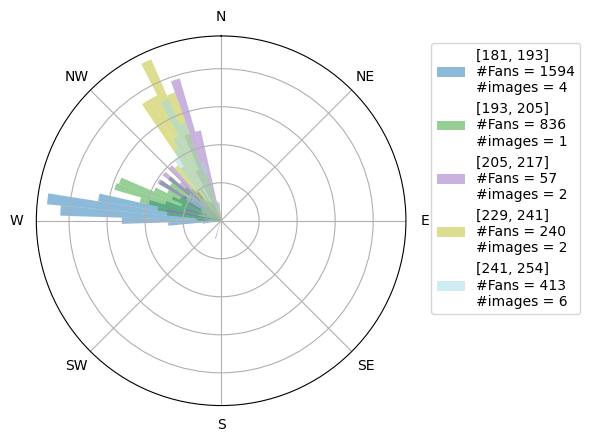

In [47]:
obsid_potsdam = [
    'ESP_011526_0980',
    'ESP_012805_0980',
    'ESP_021508_0980',
    'ESP_021521_0980',
    'ESP_012515_0980',
    'ESP_012594_0980',
    'ESP_020374_0980',
    'ESP_020875_0980',
    'ESP_011460_0980',
    'ESP_021574_0980',
    'ESP_020941_0980',
    'ESP_011737_0980',
    'ESP_012871_0980',
    'ESP_021587_0980',
    'ESP_022510_0980',
    'ESP_020163_0980',
    'PSP_004775_0980']

## Point the read_csv to your file location.
fpath = "../../../../Data/P4_catalog_Full_Release_v3.0/P4_catalog_Full_Release_v3.0_L1C_cut_0.5_fan_meta_merged.csv"
Data = pd.read_csv(fpath)
Data = Data[Data.obsid.isin(obsid_potsdam)]

histogram_polar(Data,ls_bin=6,cutoff=10)

<Axes: >

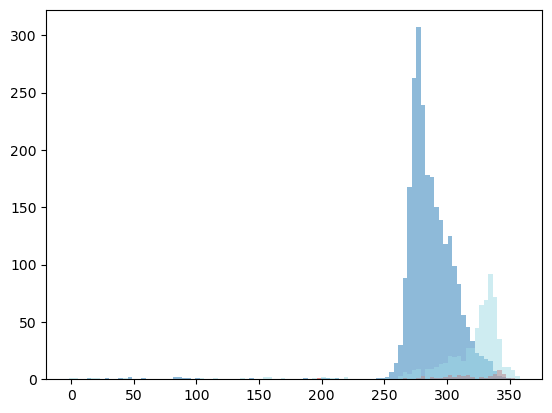

In [25]:
histogram_cartesian(Data)

In [72]:
# | export 
import geopandas as gpd 
from typing import Optional,Union

def show_stamps(df_stamps : gpd.GeoDataFrame , mark_stamp : Optional[Union[str,list[str]]] = None, ax=None):

    if ax is None:
        fig,ax = plt.subplots()
    
    df_stamps.plot(ax=ax,color="gold",edgecolor="k")

    if mark_stamp is None:
        return ax
    
    elif type(mark_stamp) is str:
        df_select = df_stamps[df_stamps.image_name == mark_stamp]
        df_select.plot(color="r",ax=ax,edgecolor="k")
    
    elif type(mark_stamp) is list:
        df_select = df_stamps[df_stamps.image_name.isin(mark_stamp)]
        df_select.plot(color="r",ax=ax, edgecolor="k")
    return ax

/home/tihro/.miniforge3/envs/planetary/lib/python3.9/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/home/tihro/.miniforge3/envs/planetary/lib/python3.9/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/home/tihro/.miniforge3/envs/planetary/lib/python3.9/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


<Axes: >

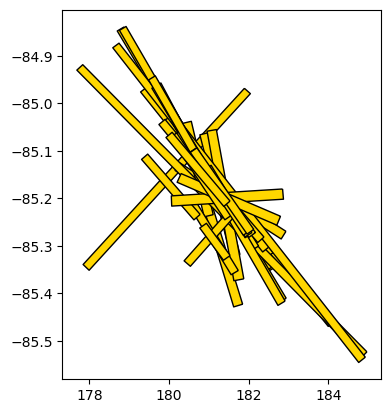

In [65]:
Stamps = gpd.read_file("../../../../Data/Obsid_stamps.gpkg")
ithaca_full = Stamps[Stamps.Region == "Ithaca"]

show_stamps(ithaca_full)

<Axes: >

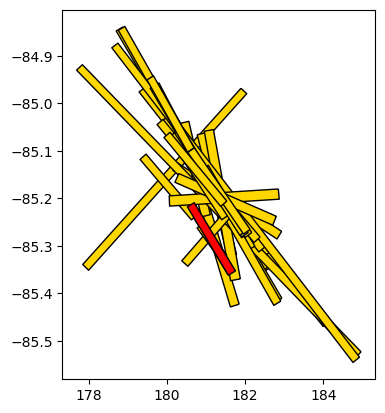

In [73]:
show_stamps(ithaca_full,mark_stamp="ESP_012854_0945")

<Axes: >

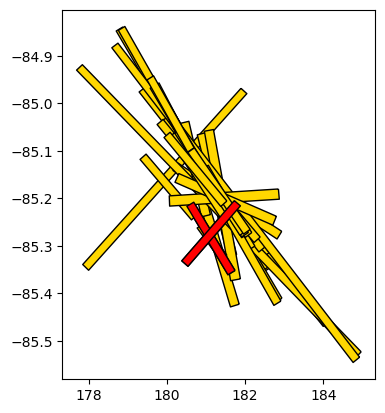

In [74]:
show_stamps(ithaca_full,mark_stamp=["ESP_012854_0945","ESP_012858_0855"])